# Neural Network Library - Milestone 1
## Gradient Checking and XOR Problem

This notebook demonstrates:
1. Gradient checking to validate backpropagation
2. Training a neural network to solve the XOR problem

## Setup

In [1]:
!pip install -q numpy matplotlib scikit-learn seaborn

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

from lib.layers import *
from lib.activations import *
from lib.losses import *
from lib.network import *
from lib.optimizer import *

### Network Visualization Function

In [3]:
def visualize_network(network, title="Neural Network Architecture"):
    """
    Visualize the neural network architecture showing neurons and connections.
    
    Args:
        network: Sequential network to visualize
        title: Title for the plot
    """
    # Extract layer information
    layer_sizes = []
    layer_types = []
    
    for layer in network.layers:
        if hasattr(layer, "weights"):  # Dense layer
            if not layer_sizes:  # First layer
                layer_sizes.append(layer.weights.shape[0])  # Input size
            layer_sizes.append(layer.weights.shape[1])  # Output size
            layer_types.append("Dense")
        else:  # Activation layer
            layer_types.append(type(layer).__name__)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(27, 9))
    ax.axis("off")
    ax.set_aspect('equal')
    
    # Calculate positions
    num_layers = len(layer_sizes)
    max_neurons = max(layer_sizes)
    
    # Horizontal spacing between layers
    h_spacing = 1.0 / (num_layers + 1)
    
    # Store neuron positions for drawing connections
    neuron_positions = []
    
    # Draw neurons for each layer
    for layer_idx, num_neurons in enumerate(layer_sizes):
        # Vertical spacing for this layer
        v_spacing = 1.0 / (num_neurons + 1)
        
        layer_positions = []
        x = (layer_idx + 1) * h_spacing
        
        for neuron_idx in range(num_neurons):
            y = (neuron_idx + 1) * v_spacing
            layer_positions.append((x, y))
            
            # Draw neuron as circle
            circle = plt.Circle((x, y), 0.02, color="steelblue", ec="black", linewidth=2, zorder=4)
            ax.add_patch(circle)
        
        neuron_positions.append(layer_positions)
        
        # Add layer label
        if layer_idx == 0:
            label = f"Input\n({num_neurons})"
        elif layer_idx == num_layers - 1:
            label = f"Output\n({num_neurons})"
        else:
            label = f"Hidden {layer_idx}\n({num_neurons})"
        
        ax.text(x, -0.05, label, ha="center", va="top", fontsize=11, fontweight="bold")
    
    # Draw connections between layers
    for layer_idx in range(len(neuron_positions) - 1):
        for start_pos in neuron_positions[layer_idx]:
            for end_pos in neuron_positions[layer_idx + 1]:
                # Draw line connecting neurons
                ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 
                       color="black", alpha=0.8, linewidth=0.5, zorder=1)
    
    # Add activation function labels between layers
    activation_idx = 0
    for layer_idx in range(len(layer_sizes) - 1):
        if activation_idx < len(layer_types):
            # Find the activation after this dense layer
            if layer_types[activation_idx] == "Dense":
                activation_idx += 1
            
            if activation_idx < len(layer_types):
                activation_name = layer_types[activation_idx]
                x_mid = ((layer_idx + 1) * h_spacing + (layer_idx + 2) * h_spacing) / 2
                
                # Draw activation box
                box_width = 0.08
                box_height = 0.06
                rect = plt.Rectangle((x_mid - box_width/2, 0.5 - box_height/2), 
                                    box_width, box_height, 
                                    facecolor="lightcoral", edgecolor="black", 
                                    linewidth=1.5, zorder=3)
                ax.add_patch(rect)
                ax.text(x_mid, 0.5, activation_name, ha="center", va="center", 
                       fontsize=9, fontweight="bold", zorder=5)
                
                activation_idx += 1
    
    # Set axis limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.15, 1.05)
    
    # Add title
    ax.text(0.5, 1.02, title, ha="center", va="bottom", 
           fontsize=16, fontweight="bold", transform=ax.transAxes)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="steelblue", edgecolor="black", label="Neuron"),
        Patch(facecolor="lightcoral", edgecolor="black", label="Activation"),
        plt.Line2D([0], [0], color="gray", alpha=0.3, linewidth=2, label="Connection")
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=10)
    
    plt.tight_layout()
    plt.show()


## Section 1: Gradient Checking

Gradient checking validates that backpropagation implementation is correct by comparing analytical gradients with numerical gradients.

**Numerical Gradient Formula:**
$$\frac{\partial L}{\partial W} \approx \frac{L(W + \epsilon) - L(W - \epsilon)}{2\epsilon}$$

### Gradient Checker Implementation

In [4]:
class GradientChecker:
    """
    Validates backpropagation by comparing analytical gradients (from backprop)
    with numerical gradients.
    
    The numerical gradient approximates the derivative using:
        f'(x) = [f(x + ε) - f(x - ε)] / (2ε)
    
    If backprop is correct, analytical and numerical gradients should match.
    """
    
    def __init__(self, epsilon=1e-7, tolerance=1e-5):
        """
        Args:
            epsilon: Small value for finite difference approximation
            tolerance: Maximum acceptable relative error
        """
        self.epsilon = epsilon
        self.tolerance = tolerance
    
    def check_layer(self, layer, inputs, grad_output):
        """
        Check if layer's backpropagation is correct.
        
        Args:
            layer: Layer to test (e.g., Dense)
            inputs: Input data for forward pass
            grad_output: Gradient flowing back from next layer
        
        Returns:
            bool: True if all gradients pass the check
        """
        # Step 1: Run forward pass to compute outputs
        layer.forward(inputs)
        
        # Step 2: Run backward pass to compute analytical gradients
        # These are the gradients computed by the backprop implementation
        layer.backward(grad_output)
        analytical_grads = layer.get_gradients()
        
        # Step 3: Compute numerical gradients using finite differences
        # These approximate the true gradients by perturbing each parameter
        numerical_grads = self._compute_numerical_gradients(layer, inputs, grad_output)
        
        # Step 4: Compare analytical vs numerical gradients
        passed = True
        param_names = ['weights', 'biases'] if hasattr(layer, 'weights') else []
        
        for i, (analytical, numerical) in enumerate(zip(analytical_grads, numerical_grads)):
            if analytical is None:
                continue
            
            # Compute relative error between the two gradients
            error = self._relative_error(analytical, numerical)
            param_name = param_names[i] if i < len(param_names) else f'param_{i}'
            
            # Print detailed comparison
            print(f'\n  {param_name}:')
            print(f'    Analytical gradient norm: {np.linalg.norm(analytical):.6f}')
            print(f'    Numerical gradient norm:  {np.linalg.norm(numerical):.6f}')
            print(f'    Relative error:           {error:.2e}')
            print(f'    Tolerance:                {self.tolerance:.2e}')
            
            status = '✓ PASSED' if error < self.tolerance else '✗ FAILED'
            print(f'    Status: {status}')
            
            if error >= self.tolerance:
                passed = False
        
        return passed
    
    def _compute_numerical_gradients(self, layer, inputs, grad_output):
        """
        Compute numerical gradients using finite differences.
        
        For each parameter w, we compute:
            ∂L/∂w ≈ [L(w + ε) - L(w - ε)] / (2ε)
        
        This is done by:
        1. Change parameter by +ε, compute loss
        2. Change parameter by -ε, compute loss
        3. Gradient = (loss_plus - loss_minus) / (2ε)
        4. Restore original parameter value
        """
        parameters = layer.get_parameters()
        numerical_grads = []
        
        for param in parameters:
            numerical_grad = np.zeros_like(param)
            
            # Iterate over each element in the parameter array
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            
            while not it.finished:
                idx = it.multi_index
                original = param[idx]
                
                # Compute f(x + epsilon)
                param[idx] = original + self.epsilon
                output_plus = layer.forward(inputs)
                loss_plus = np.sum(grad_output * output_plus)
                
                # Compute f(x - epsilon)
                param[idx] = original - self.epsilon
                output_minus = layer.forward(inputs)
                loss_minus = np.sum(grad_output * output_minus)
                
                # Numerical gradient using central difference
                numerical_grad[idx] = (loss_plus - loss_minus) / (2 * self.epsilon)
                
                # Restore original value
                param[idx] = original
                it.iternext()
            
            numerical_grads.append(numerical_grad)
        
        return numerical_grads
    
    def _relative_error(self, analytical, numerical):
        """
        Compute relative error between analytical and numerical gradients.
        
        Relative error = |analytical - numerical| / max(|analytical|, |numerical|)
        
        This normalizes the error by the magnitude of the gradients,
        making it scale-invariant.
        """
        diff = np.abs(analytical.flatten() - numerical.flatten())
        denom = np.maximum(
            np.maximum(np.abs(analytical.flatten()), np.abs(numerical.flatten())),
            1e-12  # Avoid division by zero
        )
        return np.max(diff / denom)



### Test 1: Dense Layer Gradients

In [5]:
# Test Dense layer gradients
print('Testing Dense Layer Gradients')
print('=' * 50)
print('\nDense layer has two parameters to check:')
print('  1. Weights: ∂L/∂W (gradient w.r.t. weight matrix)')
print('  2. Biases:  ∂L/∂b (gradient w.r.t. bias vector)')

# Create a small Dense layer for testing
layer = Dense(3, 2)  # 3 inputs → 2 outputs
layer.weights = np.random.randn(3, 2) * 0.1
layer.biases = np.zeros((1, 2))

# Create test inputs and gradients
inputs = np.random.randn(2, 3)        # Batch of 2 samples, 3 features each
grad_output = np.random.randn(2, 2) * 0.5  # Gradient from next layer

print(f'\nTest setup:')
print(f'  Input shape:       {inputs.shape}')
print(f'  Weights shape:     {layer.weights.shape}')
print(f'  Biases shape:      {layer.biases.shape}')
print(f'  Grad output shape: {grad_output.shape}')

# Run gradient check
checker = GradientChecker()
passed = checker.check_layer(layer, inputs, grad_output)

print(f'\n{"="*50}')
print(f'Overall Result: {"✓ PASSED" if passed else "✗ FAILED"}')
print(f'{"="*50}\n')

Testing Dense Layer Gradients

Dense layer has two parameters to check:
  1. Weights: ∂L/∂W (gradient w.r.t. weight matrix)
  2. Biases:  ∂L/∂b (gradient w.r.t. bias vector)

Test setup:
  Input shape:       (2, 3)
  Weights shape:     (3, 2)
  Biases shape:      (1, 2)
  Grad output shape: (2, 2)

  weights:
    Analytical gradient norm: 1.584192
    Numerical gradient norm:  1.584192
    Relative error:           1.10e-10
    Tolerance:                1.00e-05
    Status: ✓ PASSED

  biases:
    Analytical gradient norm: 1.031014
    Numerical gradient norm:  1.031014
    Relative error:           7.98e-11
    Tolerance:                1.00e-05
    Status: ✓ PASSED

Overall Result: ✓ PASSED



### Test 2: Activation Function Gradients

In [6]:
# Test activation functions
print('Testing Activation Functions')
print('=' * 50)
print('\nActivations have no learnable parameters, so we test:')
print('  1. Forward pass: output = activation(input)')
print('  2. Backward pass: gradient computation')

np.random.seed(123)
inputs = np.random.randn(3, 4)
grad_output = np.random.randn(3, 4)

# ============ ReLU ============
print('\n' + '-'*50)
print('ReLU: f(x) = max(0, x)')
print('-'*50)

relu = ReLU()
output = relu.forward(inputs)
grad = relu.backward(grad_output)

# Expected behavior
expected_output = np.maximum(0, inputs)
expected_grad = grad_output * (inputs > 0)  # Gradient is 0 where input < 0

forward_ok = np.allclose(output, expected_output)
backward_ok = np.allclose(grad, expected_grad)

print(f'Forward pass:')
print(f'  Computed output norm: {np.linalg.norm(output):.6f}')
print(f'  Expected output norm: {np.linalg.norm(expected_output):.6f}')
print(f'  Match: {"✓" if forward_ok else "✗"}')

print(f'\nBackward pass:')
print(f'  Computed gradient norm: {np.linalg.norm(grad):.6f}')
print(f'  Expected gradient norm: {np.linalg.norm(expected_grad):.6f}')
print(f'  Match: {"✓" if backward_ok else "✗"}')

relu_ok = forward_ok and backward_ok
print(f'\nResult: {"✓ PASSED" if relu_ok else "✗ FAILED"}')

# ============ Sigmoid ============
print('\n' + '-'*50)
print('Sigmoid: f(x) = 1 / (1 + e^(-x))')
print('-'*50)

sigmoid = Sigmoid()
output = sigmoid.forward(inputs)
grad = sigmoid.backward(grad_output)

expected_output = 1.0 / (1.0 + np.exp(-inputs))
expected_grad = grad_output * (output * (1.0 - output))  # Derivative: σ(x) * (1 - σ(x))

forward_ok = np.allclose(output, expected_output)
backward_ok = np.allclose(grad, expected_grad)

print(f'Forward pass:')
print(f'  Computed output norm: {np.linalg.norm(output):.6f}')
print(f'  Expected output norm: {np.linalg.norm(expected_output):.6f}')
print(f'  Match: {"✓" if forward_ok else "✗"}')

print(f'\nBackward pass:')
print(f'  Computed gradient norm: {np.linalg.norm(grad):.6f}')
print(f'  Expected gradient norm: {np.linalg.norm(expected_grad):.6f}')
print(f'  Match: {"✓" if backward_ok else "✗"}')

sigmoid_ok = forward_ok and backward_ok
print(f'\nResult: {"✓ PASSED" if sigmoid_ok else "✗ FAILED"}')

# ============ Tanh ============
print('\n' + '-'*50)
print('Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))')
print('-'*50)

tanh = Tanh()
output = tanh.forward(inputs)
grad = tanh.backward(grad_output)

expected_output = np.tanh(inputs)
expected_grad = grad_output * (1.0 - np.square(output))  # Derivative: 1 - tanh²(x)

forward_ok = np.allclose(output, expected_output)
backward_ok = np.allclose(grad, expected_grad)

print(f'Forward pass:')
print(f'  Computed output norm: {np.linalg.norm(output):.6f}')
print(f'  Expected output norm: {np.linalg.norm(expected_output):.6f}')
print(f'  Match: {"✓" if forward_ok else "✗"}')

print(f'\nBackward pass:')
print(f'  Computed gradient norm: {np.linalg.norm(grad):.6f}')
print(f'  Expected gradient norm: {np.linalg.norm(expected_grad):.6f}')
print(f'  Match: {"✓" if backward_ok else "✗"}')

tanh_ok = forward_ok and backward_ok
print(f'\nResult: {"✓ PASSED" if tanh_ok else "✗ FAILED"}')

print('\n' + '='*50)
all_passed = relu_ok and sigmoid_ok and tanh_ok
print(f'All Activations: {"✓ PASSED" if all_passed else "✗ FAILED"}')
print('='*50 + '\n')

Testing Activation Functions

Activations have no learnable parameters, so we test:
  1. Forward pass: output = activation(input)
  2. Backward pass: gradient computation

--------------------------------------------------
ReLU: f(x) = max(0, x)
--------------------------------------------------
Forward pass:
  Computed output norm: 2.324782
  Expected output norm: 2.324782
  Match: ✓

Backward pass:
  Computed gradient norm: 2.435377
  Expected gradient norm: 2.435377
  Match: ✓

Result: ✓ PASSED

--------------------------------------------------
Sigmoid: f(x) = 1 / (1 + e^(-x))
--------------------------------------------------
Forward pass:
  Computed output norm: 1.728296
  Expected output norm: 1.728296
  Match: ✓

Backward pass:
  Computed gradient norm: 0.843999
  Expected gradient norm: 0.843999
  Match: ✓

Result: ✓ PASSED

--------------------------------------------------
Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))
--------------------------------------------------
Forward

### Test 3: MSE Loss Gradients

In [7]:
# Test MSE Loss gradients
print('Testing MSE Loss Gradients')
print('=' * 50)
print('\nMSE Loss: L = (1/N) * Σ(prediction - target)²')
print('Gradient: ∂L/∂prediction = (2/N) * (prediction - target)')

loss_fn = MSELoss()
np.random.seed(127)
predictions = np.random.randn(3, 2) * 0.5
targets = np.random.randn(3, 2) * 0.5

print(f'\nTest setup:')
print(f'  Predictions shape: {predictions.shape}')
print(f'  Targets shape:     {targets.shape}')
print(f'  Total elements:    {predictions.size}')

# Compute loss and gradient
loss = loss_fn.forward(predictions, targets)
grad = loss_fn.backward(predictions, targets)

# Expected gradient formula
N = predictions.size
expected_grad = (2.0 / N) * (predictions - targets)

print(f'\nLoss value: {loss:.6f}')

print(f'\nGradient comparison:')
print(f'  Computed gradient norm: {np.linalg.norm(grad):.6f}')
print(f'  Expected gradient norm: {np.linalg.norm(expected_grad):.6f}')
print(f'  Max absolute difference: {np.max(np.abs(grad - expected_grad)):.2e}')

mse_ok = np.allclose(grad, expected_grad)
print(f'\n{"="*50}')
print(f'Result: {"✓ PASSED" if mse_ok else "✗ FAILED"}')
print(f'{"="*50}\n')

Testing MSE Loss Gradients

MSE Loss: L = (1/N) * Σ(prediction - target)²
Gradient: ∂L/∂prediction = (2/N) * (prediction - target)

Test setup:
  Predictions shape: (3, 2)
  Targets shape:     (3, 2)
  Total elements:    6

Loss value: 0.567807

Gradient comparison:
  Computed gradient norm: 0.615254
  Expected gradient norm: 0.615254
  Max absolute difference: 0.00e+00

Result: ✓ PASSED



## Section 2: XOR Problem

The XOR problem is a classic test for neural networks. It's non-linearly separable and requires a hidden layer.

**XOR Truth Table:**
```
0 XOR 0 = 0
0 XOR 1 = 1
1 XOR 0 = 1
1 XOR 1 = 0
```

### Create XOR Dataset

In [8]:
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
y = np.array([[0],[1],[1],[0]], dtype=np.float32)

print('XOR Dataset:')
print('Inputs (X):')
print(X)
print('\nTargets (y):')
print(y)

XOR Dataset:
Inputs (X):
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

Targets (y):
[[0.]
 [1.]
 [1.]
 [0.]]


### Build Network

Architecture: 2 [Input] - 4 (Tanh) - 1 (Sigmoid) [Output]

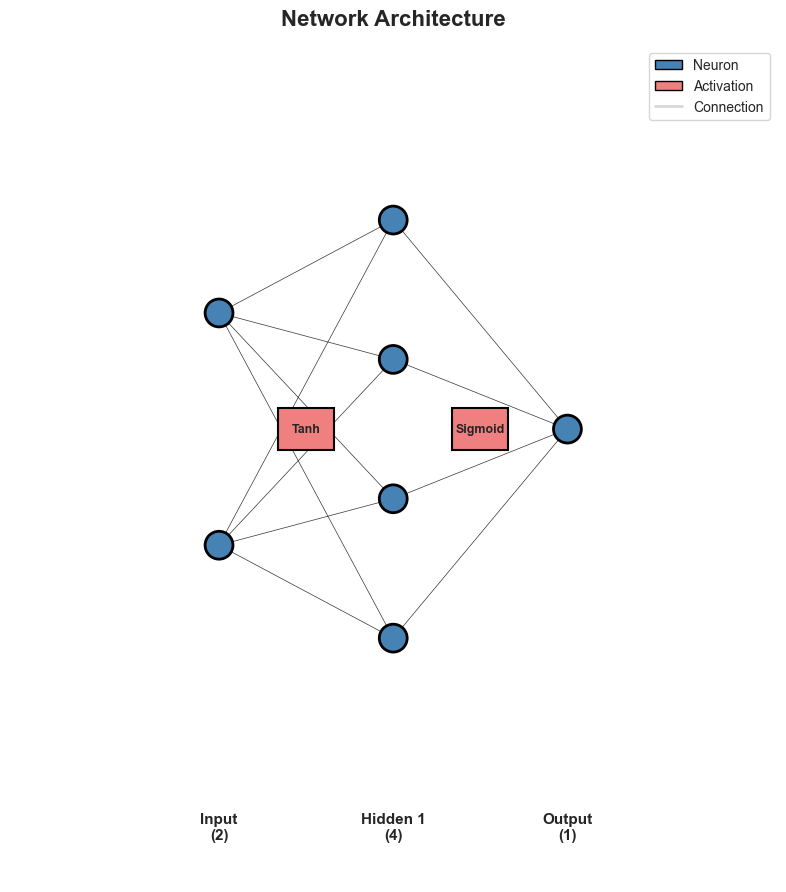

In [9]:
network = Sequential()
network.add(Dense(2, 4))
network.add(Tanh())
network.add(Dense(4, 1))
network.add(Sigmoid())

visualize_network(network, "Network Architecture")


### Train Network

In [10]:
loss_fn = MSELoss()
optimizer = SGD(learning_rate=0.1)

print('Training XOR Network (2→4→1)')
print('-' * 40)

# Get predictions before training
preds_before = network.predict(X)

history = []
for epoch in range(2000):
    loss = network.train_step(X, y, loss_fn, optimizer)
    history.append(loss)
    
    if loss < 0.01:
        print(f'Converged at epoch {epoch+1}')
        break
    
    if (epoch+1) % 400 == 0:
        print(f'Epoch {epoch+1}: Loss = {loss:.6f}')

print(f'Final loss: {history[-1]:.6f}\n')

Training XOR Network (2→4→1)
----------------------------------------
Epoch 400: Loss = 0.245623
Epoch 800: Loss = 0.202809
Epoch 1200: Loss = 0.075797
Epoch 1600: Loss = 0.024835
Epoch 2000: Loss = 0.012658
Final loss: 0.012658



### Evaluate Results

### Visualize Before and After Training

Creating before/after training comparison...


C:\Users\rocke\AppData\Local\Temp\ipykernel_26996\3525200526.py:86: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rocke\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


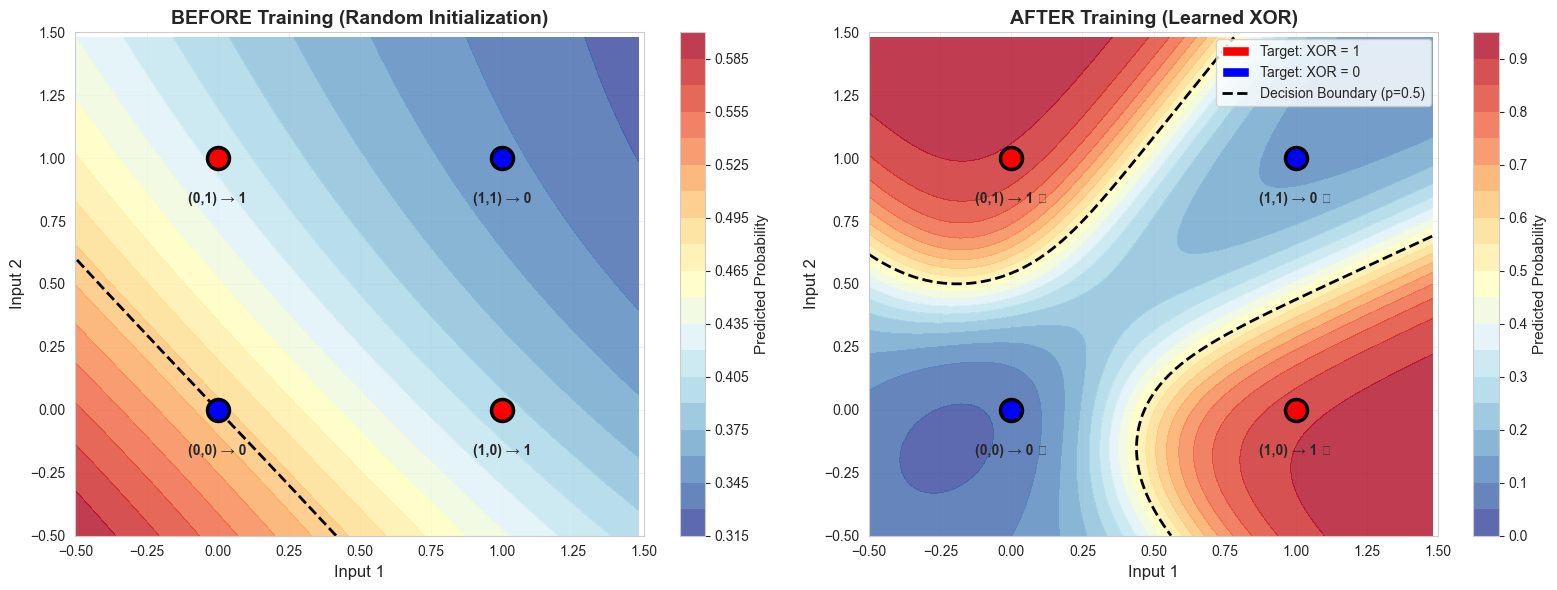

In [11]:
# Create before/after comparison visualization
print('Creating before/after training comparison...')

# Create mesh for decision boundary
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

# We need to recreate the untrained network for 'before' visualization
# Save current trained network
trained_network = network

# Create untrained network with same architecture
np.random.seed(42)  # Use same seed for reproducibility
untrained_network = Sequential()
untrained_network.add(Dense(2, 4))
untrained_network.add(Tanh())
untrained_network.add(Dense(4, 1))
untrained_network.add(Sigmoid())

# Get predictions from both networks
Z_before = untrained_network.predict(mesh_points).reshape(xx.shape)
Z_after = trained_network.predict(mesh_points).reshape(xx.shape)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: BEFORE training
contour1 = ax1.contourf(xx, yy, Z_before, levels=20, cmap='RdYlBu_r', alpha=0.8)
ax1.contour(xx, yy, Z_before, levels=[0.5], colors='black', linewidths=2, linestyles='--')
cbar1 = plt.colorbar(contour1, ax=ax1)
cbar1.set_label('Predicted Probability', fontsize=11)

# Plot XOR points
colors = ['blue' if y[i][0] == 0 else 'red' for i in range(len(y))]
for i in range(len(X)):
    ax1.scatter(X[i, 0], X[i, 1], c=colors[i], s=250, 
               marker='o', edgecolors='black', linewidths=2.5, zorder=5)
    ax1.text(X[i, 0], X[i, 1] - 0.18, f'({int(X[i, 0])},{int(X[i, 1])}) → {int(y[i, 0])}',
            ha='center', fontsize=10, fontweight='bold')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('Input 1', fontsize=12)
ax1.set_ylabel('Input 2', fontsize=12)
ax1.set_title('BEFORE Training (Random Initialization)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: AFTER training
contour2 = ax2.contourf(xx, yy, Z_after, levels=20, cmap='RdYlBu_r', alpha=0.8)
ax2.contour(xx, yy, Z_after, levels=[0.5], colors='black', linewidths=2, linestyles='--')
cbar2 = plt.colorbar(contour2, ax=ax2)
cbar2.set_label('Predicted Probability', fontsize=11)

# Plot XOR points with correct/incorrect markers
preds_final = trained_network.predict(X)
binary_preds_final = (preds_final > 0.5).astype(int)

for i in range(len(X)):
    marker = 'o' if binary_preds_final[i][0] == y[i][0] else 'X'
    ax2.scatter(X[i, 0], X[i, 1], c=colors[i], s=250, 
               marker=marker, edgecolors='black', linewidths=2.5, zorder=5)
    status = '✓' if binary_preds_final[i][0] == y[i][0] else '✗'
    ax2.text(X[i, 0], X[i, 1] - 0.18, f'({int(X[i, 0])},{int(X[i, 1])}) → {int(y[i, 0])} {status}',
            ha='center', fontsize=10, fontweight='bold')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Input 1', fontsize=12)
ax2.set_ylabel('Input 2', fontsize=12)
ax2.set_title('AFTER Training (Learned XOR)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Target: XOR = 1'),
    Patch(facecolor='blue', label='Target: XOR = 0'),
    plt.Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Decision Boundary (p=0.5)')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Restore the trained network
network = trained_network

In [12]:
preds = network.predict(X)
binary_preds = (preds > 0.5).astype(int)
accuracy = np.mean(binary_preds == y.astype(int))

print('XOR Results')
print('-' * 40)
print('Input  | Target | Prediction | Result')
print('-' * 40)

for i in range(len(X)):
    correct = '✓' if binary_preds[i][0] == int(y[i][0]) else '✗'
    print(f'{X[i]}  |   {int(y[i][0])}    |   {preds[i][0]:.4f}   | {correct}')

print('-' * 40)
print(f'Accuracy: {accuracy*100:.0f}%\n')

XOR Results
----------------------------------------
Input  | Target | Prediction | Result
----------------------------------------
[0. 0.]  |   0    |   0.0647   | ✓
[0. 1.]  |   1    |   0.8865   | ✓
[1. 0.]  |   1    |   0.8779   | ✓
[1. 1.]  |   0    |   0.1364   | ✓
----------------------------------------
Accuracy: 100%



### Visualize Training

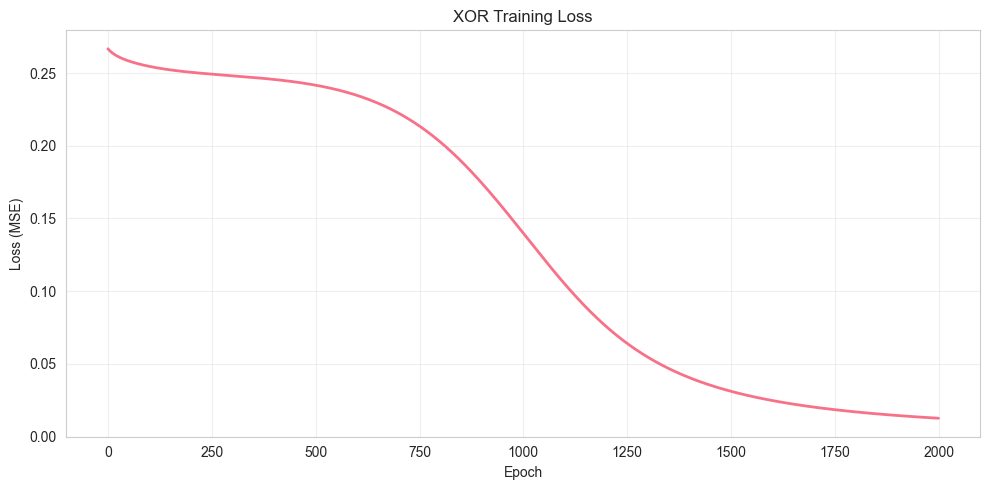

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('XOR Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3D Network Output Surface

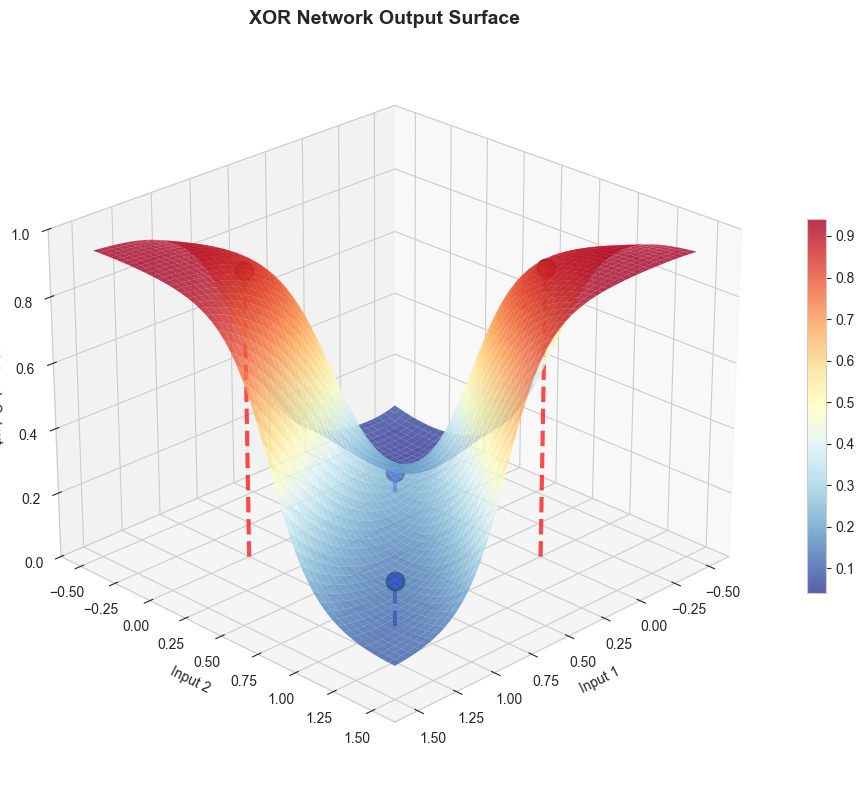

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D surface
x_range = np.linspace(-0.5, 1.5, 50)
y_range = np.linspace(-0.5, 1.5, 50)
xx_3d, yy_3d = np.meshgrid(x_range, y_range)
mesh_3d = np.c_[xx_3d.ravel(), yy_3d.ravel()].astype(np.float32)
Z_3d = network.predict(mesh_3d).reshape(xx_3d.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(xx_3d, yy_3d, Z_3d, cmap='RdYlBu_r', alpha=0.8, edgecolor='none')

# Plot XOR points
for i in range(len(X)):
    color = 'red' if y[i][0] == 1 else 'blue'
    ax.plot([X[i, 0], X[i, 0]], [X[i, 1], X[i, 1]], [0, preds[i][0]], 
           color=color, linewidth=3, linestyle='--', alpha=0.7)
    ax.scatter(X[i, 0], X[i, 1], preds[i][0], c=color, s=150, edgecolors='black', linewidths=2)

# Decision plane at z=0.5
# ax.plot_surface(xx_3d, yy_3d, np.ones_like(Z_3d) * 0.5, alpha=0.1, color='gray')

ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Network Output')
ax.set_title('XOR Network Output Surface', fontsize=14, fontweight='bold')
ax.view_init(elev=25, azim=45)
ax.set_zlim(0, 1)

plt.colorbar(surf, ax=ax, shrink=0.5)
plt.tight_layout()
plt.show()

In [15]:
network.predict([10,10])

array([[0.0791211]])